In [1]:
import torch
import matplotlib.pyplot as plt
from kan import MultKAN
from kan import KAN, create_dataset
from torch.utils.data import TensorDataset, DataLoader
from scipy import special
import numpy as np
import time
from kan import feynman
import torch.optim as optim

In [2]:
pi = torch.pi
# sec 3.1 toy datasets

f1 = lambda x: special.jn(0, 20*x[:,0])  
f2 = lambda x: torch.exp(x[:,1]**2  + torch.sin(x[:,0]*pi))
f3 = lambda x: x[:,0]*x[:,1]
f4 = lambda x: torch.exp(
    0.01 * torch.sum(torch.stack([
        (torch.sin(0.5 * pi * x[:, i]))**2 for i in range(100)
    ], dim=0), dim=0)
).reshape(-1, 1)
f5 = lambda x: torch.exp(0.5*(torch.sin(pi*(x[:,0]**2 + x[:,1]**2))+torch.sin(pi*(x[:,2]**2 + x[:,3]**2))))

## Feynman datasets (dimensionless formula)
# 
f6 = lambda x: x[:,0]*(1/x[:,1] - 1) # used [2, 2, 1]
f7 = lambda x: 1 + x[:,0]*torch.sin(pi*x[:,1]) # used [2, 2, 2, 1]
f8 = lambda x: x[:,0]*torch.exp(-x[:,1]) # used [2, 1, 1]
# f9 = x/y
f9 = lambda x: x[:,0] / (x[:,1] + 1e-5) # used [2, 1, 1]
# f10 = (1+a**2+b**2)**0.5
f10 = lambda x: torch.sqrt(1 + x[:,0]**2 + x[:,1]**2) # used [2, 1, 1]



In [3]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, output_dim=1):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, hidden_dim//4),
            nn.ReLU(),
            nn.Linear(hidden_dim//4, output_dim)
        )

    def forward(self, x):
        return self.model(x)
    



class MLP_2(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, output_dim=1):
        super(MLP_2, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, output_dim)
        )

    def forward(self, x):
        return self.model(x)
    
class MLP_4(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, output_dim=1):
        super(MLP_4, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, hidden_dim//4),
            nn.ReLU(),
            nn.Linear(hidden_dim//4, hidden_dim//4),
            nn.ReLU(),
            nn.Linear(hidden_dim//4, output_dim)
        )

    def forward(self, x):
        return self.model(x)
    


def train_mlp_lbfgs(model, x_train, y_train, max_iter=100):
    loss_fn = nn.MSELoss()
    optimizer = optim.LBFGS(model.parameters(), lr=0.5, max_iter=max_iter, history_size=10, line_search_fn="strong_wolfe")

    def closure():
        optimizer.zero_grad()
        pred = model(x_train)
        loss = loss_fn(pred, y_train)
        loss.backward()
        return loss

    optimizer.step(closure)


In [4]:
from torch.nn import functional as F

In [5]:
mlp_param_list = []
mlp_mse_list = []

kan_param_list = []
kan_mse_list = []
mlp_param_list_2 = []
mlp_mse_list_2 = []
mlp_train_time_2 = []

mlp_param_list_4 = []
mlp_mse_list_4 = []
mlp_train_time_4 = []


kan_train_time = []
mlp_train_time = []

hidden_sizes = [8, 16, 32, 48, 64, 80]
grid_sizes = [3, 5, 8, 16, 20, 50, 90]
input_dimention = 2
dataset = create_dataset(f2, n_var=input_dimention)
width = [2, 1, 1]
 #change f1 to other function names for testing on desired function for graphs

x_train = dataset['train_input']
y_train = dataset['train_label']
x_test = dataset['test_input']
y_test = dataset['test_label']

train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test, y_test), batch_size=128)

for h in hidden_sizes:
    # === MLP ===
    # mlp_model = MLP(input_dim=1, hidden_dim=h, output_dim=1)
    # optimizer = torch.optim.Adam(mlp_model.parameters(), lr=0.001)
    # loss_fn = nn.MSELoss()

    # start = time.time()
    # for epoch in range(50):
    #     mlp_model.train()
    #     for xb, yb in train_loader:
    #         pred = mlp_model(xb)
    #         loss = loss_fn(pred, yb)
    #         optimizer.zero_grad()
    #         loss.backward()
    #         optimizer.step()
    # end = time.time()

    mlp_model = MLP(input_dim=input_dimention, hidden_dim=h, output_dim=1)
    start = time.time()
    train_mlp_lbfgs(mlp_model,x_train,y_train)
    end = time.time()
    with torch.no_grad():
        mlp_pred = mlp_model(x_test)
        mlp_mse = F.mse_loss(mlp_pred, y_test).item()

    count= 0
    for p in mlp_model.parameters():
      if p.requires_grad:
        p_count = p.numel()
        count += p_count
    mlp_param_list.append(count)
    mlp_mse_list.append(mlp_mse)
    mlp_train_time.append(end-start)


    #===mlp_2===============================================================================

    mlp_model = MLP_2(input_dim=input_dimention, hidden_dim=h, output_dim=1)
    start = time.time()
    train_mlp_lbfgs(mlp_model,x_train,y_train)
    end = time.time()
    with torch.no_grad():
        mlp_pred = mlp_model(x_test)
        mlp_mse = F.mse_loss(mlp_pred, y_test).item()

    count= 0
    for p in mlp_model.parameters():
      if p.requires_grad:
        p_count = p.numel()
        count += p_count
    mlp_param_list_2.append(count)
    mlp_mse_list_2.append(mlp_mse)
    mlp_train_time_2.append(end-start)
# ============================================================================================
    mlp_model = MLP_4(input_dim=input_dimention, hidden_dim=h, output_dim=1)
    start = time.time()
    train_mlp_lbfgs(mlp_model,x_train,y_train)
    end = time.time()
    with torch.no_grad():
        mlp_pred = mlp_model(x_test)
        mlp_mse = F.mse_loss(mlp_pred, y_test).item()

    count= 0
    for p in mlp_model.parameters():
      if p.requires_grad:
        p_count = p.numel()
        count += p_count
    mlp_param_list_4.append(count)
    mlp_mse_list_4.append(mlp_mse)
    mlp_train_time_4.append(end-start)



kan_model = KAN(width=width,grid=grid_sizes[0])
for j in range(len(grid_sizes)):
    start = time.time()
    print(j)
    if j != 0: 
        kan_model = kan_model.refine(grid_sizes[j])
    kan_model.fit(dataset, steps=200)
    end = time.time()

    with torch.no_grad():
        kan_pred = kan_model(x_test)
        kan_mse = F.mse_loss(kan_pred, y_test).item()

    count = 0
    for p in kan_model.parameters():
        if p.requires_grad:
            p_count = p.numel()
            count += p_count
    kan_param_list.append(count)
    kan_mse_list.append(kan_mse)
    kan_train_time.append(end-start)




checkpoint directory created: ./model
saving model version 0.0
0


| train_loss: 1.36e-02 | test_loss: 1.39e-02 | reg: 1.17e+01 | : 100%|█| 200/200 [00:07<00:00, 27.16


saving model version 0.1
1
saving model version 0.2


| train_loss: 7.26e-03 | test_loss: 7.18e-03 | reg: 1.18e+01 | : 100%|█| 200/200 [00:06<00:00, 29.56


saving model version 0.3
2
saving model version 0.4


| train_loss: 9.00e-04 | test_loss: 9.68e-04 | reg: 1.18e+01 | : 100%|█| 200/200 [00:05<00:00, 33.87


saving model version 0.5
3
saving model version 0.6


| train_loss: 6.90e-05 | test_loss: 8.11e-05 | reg: 1.18e+01 | : 100%|█| 200/200 [00:09<00:00, 21.21


saving model version 0.7
4
saving model version 0.8


| train_loss: 3.81e-05 | test_loss: 5.48e-05 | reg: 1.18e+01 | : 100%|█| 200/200 [00:06<00:00, 30.56


saving model version 0.9
5
saving model version 0.10


| train_loss: 1.38e-05 | test_loss: 3.13e-05 | reg: 1.18e+01 | : 100%|█| 200/200 [00:08<00:00, 23.53


saving model version 0.11
6
saving model version 0.12


| train_loss: 9.86e-06 | test_loss: 3.27e-05 | reg: 1.18e+01 | : 100%|█| 200/200 [00:08<00:00, 23.02

saving model version 0.13


In [6]:
mlp_mse_list = [np.sqrt(i) for i in mlp_mse_list]
mlp_mse_list_2 = [np.sqrt(i) for i in mlp_mse_list_2]
mlp_mse_list_4 = [np.sqrt(i) for i in mlp_mse_list_4]
kan_mse_list = [np.sqrt(i) for i in kan_mse_list]

In [9]:
kan_mse_list.pop()
kan_param_list.pop()
kan_mse_list.pop()
kan_param_list.pop()

177

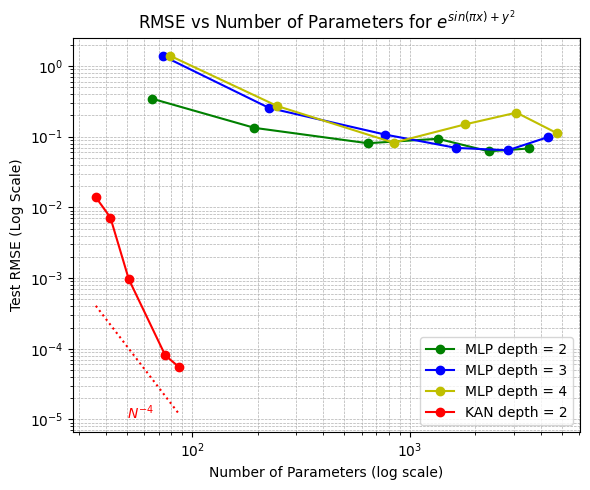

In [14]:
# === Plotting ===
plt.figure(figsize=(6, 5))
plt.plot(mlp_param_list_2, mlp_mse_list_2, 'go-', label='MLP depth = 2')
plt.plot(mlp_param_list, mlp_mse_list, 'bo-', label='MLP depth = 3')
plt.plot(mlp_param_list_4, mlp_mse_list_4, 'yo-', label='MLP depth = 4')
plt.plot(kan_param_list, kan_mse_list, 'ro-', label='KAN depth = 2')

# Generate n^-4 slope line for comparison
params = np.array(kan_param_list)
reference_point = kan_mse_list[3]
C = reference_point * (params[0] ** 4)
slope_line = C / (params ** 4)

# Add bounds (10x above and below the slope line)
upper_bound = slope_line *5000
lower_bound = slope_line *5

# Plot slope and bounds
# plt.plot(params, slope_line, 'r--', label=r'$n^{-4}$ slope')
# plt.plot(params, upper_bound, 'r:', alpha=1)
plt.plot(params, lower_bound, 'r:', alpha=1)

# plt.fill_between(params, lower_bound, upper_bound, color='red', alpha=0.1, label=r'$10^4$ bounds')
plt.xlabel("Number of Parameters (log scale)")
plt.ylabel("Test RMSE (Log Scale)")
plt.title("RMSE vs Number of Parameters for $e^{sin( \pi x) + y^2 }$")
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.text(50, 0.00001, '$N^{-4}$', fontsize=10, color='red') 
# plt.text(300, 0.001, '$N^{-4}$', fontsize=10, color='red') 
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


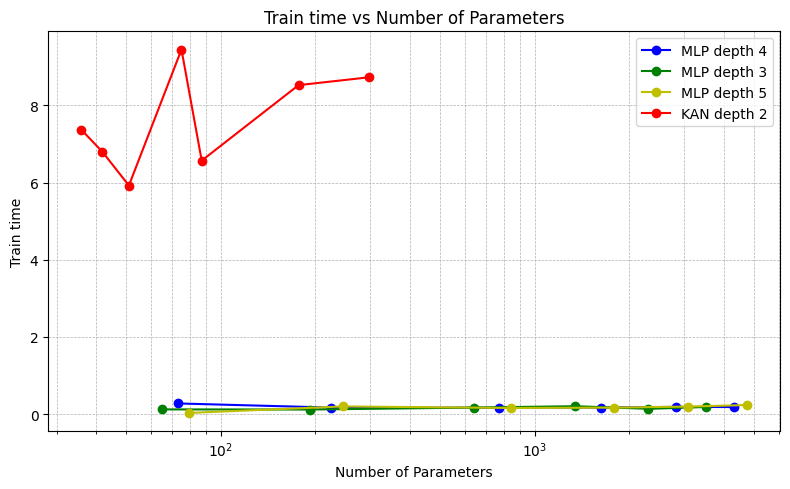

In [8]:
# === Plotting ===
plt.figure(figsize=(8, 5))
plt.plot(mlp_param_list, mlp_train_time, 'bo-', label='MLP depth 4')
plt.plot(mlp_param_list_2, mlp_train_time_2, 'go-', label='MLP depth 3')
plt.plot(mlp_param_list_4, mlp_train_time_4, 'yo-', label='MLP depth 5')
plt.plot(kan_param_list, kan_train_time, 'ro-', label='KAN depth 2')
plt.xscale("log")
plt.xlabel("Number of Parameters")
plt.ylabel("Train time")
plt.title("Train time vs Number of Parameters")
plt.legend()
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()